# Import

In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import sys
import torchviz
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
#from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network

#from PC_param import default_parameters_network
#import PC_param.ipynb
#from PC_Parameters import default_parameters_network

## !!!!! To get the parameters
import sys
#sys.path.insert(1, '/Users/knzga/Documents/folder/02_Computational Neuroscience Project/Programming/VScode/PredictiveCoding/main/Src/PC_param.ipynb')
sys.path.insert(1, '/main/CustomPackages/PC_param.py')

#https://github.com/Nozasp/PredictiveCoding/blob/main/
#main/Src

#C:\Users\knzga\Documents\02_Computational Neuroscience Project\Programming\VScode\PredictiveCoding\main\Src> 
#from PC_param import default_parameters_network #from PC_param 
from PC_param import default_parameters_network

pars = default_parameters_network()


# Function

In [13]:

#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation


def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)


def replace_argmax(logits):
    # along some dimension (e.g., the last dimension).
    indices = torch.arange(logits.shape[-1]).to(logits.device)
    #print(indices)
    return torch.gather(indices, dim=-1, index=torch.argmax(logits, dim=-1)).max()



"""### Try Normalization to "make it proba"
"""

"""
def make_it_proba(r_e):
    
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked
    baseline = 1 #1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    #I add this because when re = 0 proba becomes one everywhere. Alright?
    for i in range(r_e.shape[0]):
        if torch.sum(r_e[i,:]) == 0:
            prob_r[i,:] = 0
        else:
            prob_r = prob_r


    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?
""""""sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05"""  # to replace nan to 1/20 - to sum to 1




def make_it_proba(r_e):

    eps = torch.FloatTensor([0.001])
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

"""

def make_it_proba(r_e):

    baseline = 1 #1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    #I add this because when re = 0 proba becomes one everywhere. Alright?
    for i in range(r_e.shape[0]):
        if torch.sum(r_e[i,:]) == 0:
            prob_r[i,:] = 0
        else:
            prob_r = prob_r
    return prob_r.reshape(r_e.shape[0], r_e.shape[1]) 

"""

def make_it_proba_1d(r_e):
    baseline = 1
    sum_r_e = torch.sum(r_e) + baseline
    prob_r = torch.div(r_e +baseline, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    #prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

''' Normalization'''
#use:
#preprocessing.normalize(re_numpy, axis= 0)[20,:].sum()

#or use:
def normalize(x):
    N = (x - x.min()) / (x.max() - x.min())
    return N




"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d



"""### Optimization function"""

#Make a function which save parameters of trained model and upload the new model with the updated parameters

def model_with_saved_trained_param(old_model, optimizer, Model):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model()
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    print("old model",old_model.Jee,"new model", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer




# function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



In [14]:
#r_e.shape[0]

# Classes

## Simple Classes

In [15]:




"""
*
*
***********  CLASS
*
*
"""


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            """if fx == 0:
                fx = 1
            else: fx = fx"""
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




## Class Model

In [11]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_time(nn.Module):
    def __init__(self):
        super(MyModel_time, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulaI =torch.mul(a, I_tot)

        addB= mulaI + b

        expo = torch.exp(- (addB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




# Create stimuli Input

ic| simu.dt: 0.0001
ic| In2.shape: (499, 20)
ic| r_e.shape: torch.Size([499, 20])


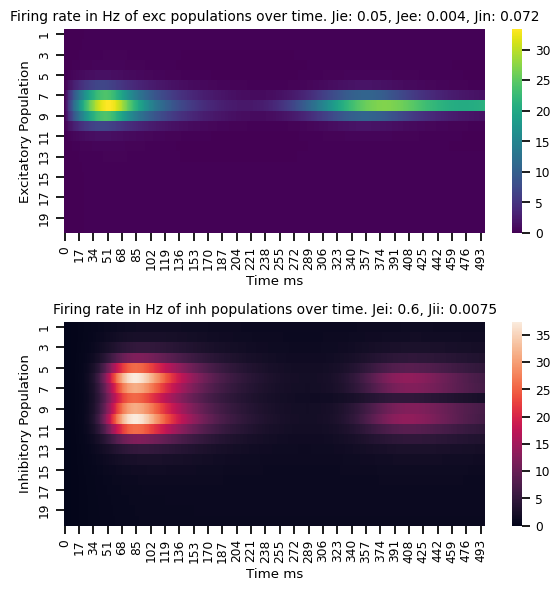

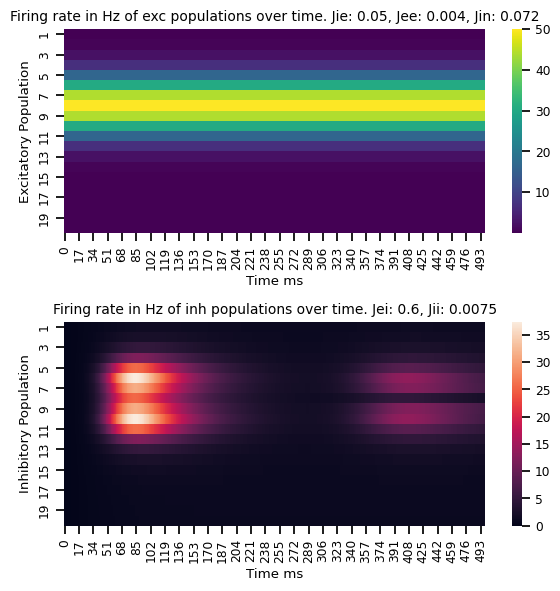

In [16]:
"""
*
*  Creat IN and Forward pass
*
*
"""


    ## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .051)#.051  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.050, f=[8], ISI=0) # dur = .005 #dur = .050 #dur=.3 ,ISI=.05    # dur = 1s Isi=1s  #dur =.2
ic(simu.dt)
In2, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.) #2.
ic(In2.shape)
#J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
#J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.0075}


J_list = list(J1.keys())

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel = MyModel_time()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e, r_i, dredt, dridt = mymodel.forward(sti)
ic(r_e.shape)
#print(torch.max(r_e[599,:]))
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)
HeatMap(sti.detach().numpy(), r_i.detach().numpy(), J1)

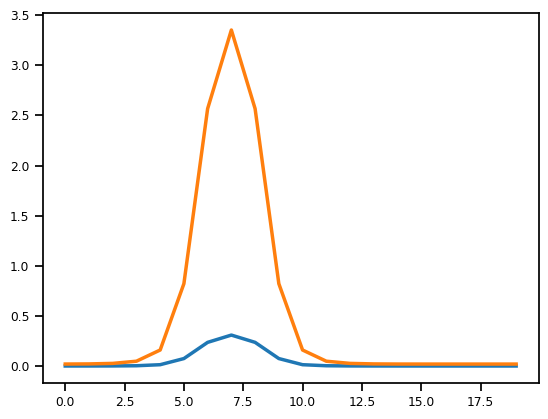

In [17]:
# cell to delete !!!!!!!!!!!!!


def make_it_proba(r_e):

    eps = torch.FloatTensor([0.002])
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    sum_max = torch.max(sum_r_e, eps)
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_max) #r_e_max.sum())

    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

prob_r = make_it_proba(r_e)

plt.plot(np.arange(0,20), prob_r[3,:].detach().numpy())
plt.plot(np.arange(0,20), r_e[3,:].detach().numpy())


# Create Batch

## Data Preparation:

### 1- create a big dataset for every stimuli . Get prediction and X stimulus

In [18]:
stimu_dur = int(stimuli.dur /simu.dt)-1 
#sti2 = int(stimuli.dur *1000)-1
print(stimu_dur)

499


In [19]:
A = np.arange(0,20)
for i in range(0, param.N):
    A[i] = (i+1)
print(A, A.shape)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (20,)


In [20]:
RE = torch.zeros(stimu_dur, 20 ,20)
RI = torch.zeros(stimu_dur, 20 ,20)
IN_T = torch.zeros(stimu_dur, 20 ,20)


param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .051) #.0051 # dt #rangeSim #dur = 2s


print(RE.shape)
print(In2.shape)
for i in range(0, param.N):
  # \\\\\\\\\\\ Bottom up sensory input
  index = i+1
  st = Stim(param,simu, dur=.050,f =[index], ISI=0) #.005 #dur = 1s Isi=1s #dur=.2 = 200ms Isi = 0.1
  In, range_sim, w, sigmaIn =st.sensoryInput(param, simu, sigmaIn = 2.)
  IN_T[:,:, i] = torch.tensor(In)
  sti = torch.tensor(In).float()
  #RE[:,:,i], RI[:,:,i], dr_e_dt, dr_i_dt = mymodel.forward(sti) #s_ampa, s_gaba, i_tot_e, i_tot_i, In,


#IN_T[1,:,2]

torch.Size([499, 20, 20])
(499, 20)


### 2- Split X into train and test dataset

Split 70% into train dataset and 30% into test dataset

In [60]:
"""rng = np.random.default_rng(1245)
dataset_size = (IN_T).shape[2]
#rand_indices = rng.integers(low=0, high= (dataset_size-1), size=19)
#print(rng.shuffle(dataset_indices))
rand_indices = np.arange(0, dataset_size)
rng.shuffle(rand_indices)

val_split_index = int(np.floor(0.7 * dataset_size))

test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]

"""

[14 15  0  3 10 16  1 19  6  7  2 17  4  9  5 11 13  8 18 12]
tensor([[1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00],
        [1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00],
        [1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00],
        ...,
        [1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00],
        [1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00],
        [1.1449e-09, 3.3458e-08, 7.6150e-07,  ..., 1.6233e+01, 6.7668e+00,
         2.1968e+00]])


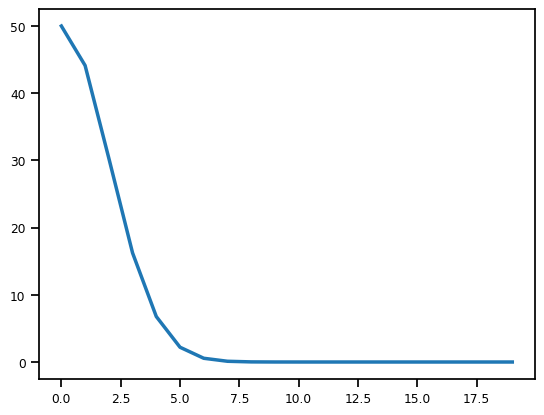

In [21]:
rng = np.random.default_rng(1245)
dataset_size = (RE).shape[2]
#rand_indices = rng.integers(low=0, high= (dataset_size-1), size=19)

rand_indices = np.arange(0, dataset_size)
rng.shuffle(rand_indices)
print(rand_indices)

val_split_index = int(np.floor(0.7 * dataset_size))

test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]


train_tensorIN = IN_T[:,:, train_idx]
test_tensorIN = IN_T[:,:, test_idx]
train_tensorRE = RE[:,:, train_idx]
test_tensorRE = RE[:,:, test_idx]
train_tensorRI = RI[:,:, train_idx]
test_tensorRI = RI[:,:, test_idx]

print(train_tensorIN[:,:,0])
plt.plot(np.arange(0,20),train_tensorIN[300,:,2])

[14 15  0  3 10 16  1 19  6  7  2 17  4  9]


In [22]:
batch_training_size = (train_idx.shape)[0]


#### 3- get expected Y - Ytarget

In [23]:
Xtrain_tensor = train_tensorIN.permute(2,0,1)#.shape
Ytrain_tensor = torch.zeros((Xtrain_tensor.shape))#, requires_grad = True)

for stimu in range(Xtrain_tensor.shape[0]):
  Ytrain_tensor[stimu,:,:] = get_expected_Y_relu(Xtrain_tensor[stimu,:,:])

### 4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)

In [24]:
## 3- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle = True) #one sample per batch

ic| X_input_proba.shape[1]: 20


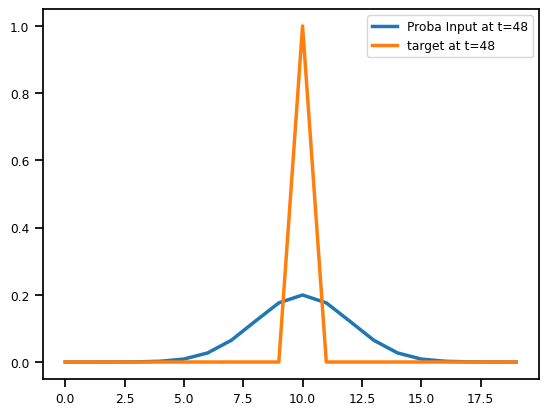

In [131]:
# 4- control what i have instide my tensors
X_input_proba = make_it_proba(Xtrain_tensor[4,:,:])
Y_target = Ytrain_tensor[4,:,:]
t=48
ic(X_input_proba.shape[1])
plt.plot(torch.arange(X_input_proba.shape[1]), X_input_proba[t,:], label= f"Proba Input at t={t}") #not in proba
plt.plot(torch.arange(Y_target.detach().numpy().shape[1]), Y_target.detach().numpy()[t,:], label = f"target at t={t}") #in proba
plt.legend()

# Optimization part

### Space for Loss design

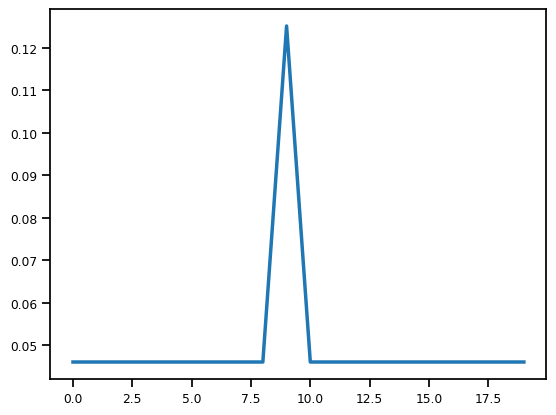

In [76]:
Y = F.softmax(Y_target, dim=-1)
plt.plot(np.arange(0, 20),Y[30,:])

In [77]:
"""lossfunc = torch.nn.NLLLoss()
BO = make_it_proba(r_e)
ic(BO.shape)
loss_proba_term = torch.zeros((r_e.shape))
logsoft = nn.LogSoftmax(dim=1)
target_pop_long =(Y_target)#, dim=-1)
pred_pop_log = F.softmax(r_e, dim=-1)#nn.LogSoftmax(dim=1)
pred_pop_log = logsoft(r_e.t())
#I = (pred_pop_log.select(0,200))
T = target_pop_long.select(0,399).long()
target_pop_long =(Y_target)#, dim=-1)
pred_pop_log = logsoft(r_e)

for t in range(r_e.shape[0]):
    ok = target_pop_long[t,:].long()    
    loss_proba_term[t,:] = lossfunc(pred_pop_log[t,:], ok)


print(loss_proba_term.mean())
### Sum over time step
#total_loss_proba_term = sum(loss_proba_term)"""



'lossfunc = torch.nn.NLLLoss()\nBO = make_it_proba(r_e)\nic(BO.shape)\nloss_proba_term = torch.zeros((r_e.shape))\nlogsoft = nn.LogSoftmax(dim=1)\ntarget_pop_long =(Y_target)#, dim=-1)\npred_pop_log = F.softmax(r_e, dim=-1)#nn.LogSoftmax(dim=1)\npred_pop_log = logsoft(r_e.t())\n#I = (pred_pop_log.select(0,200))\nT = target_pop_long.select(0,399).long()\ntarget_pop_long =(Y_target)#, dim=-1)\npred_pop_log = logsoft(r_e)\n\nfor t in range(r_e.shape[0]):\n    ok = target_pop_long[t,:].long()    \n    loss_proba_term[t,:] = lossfunc(pred_pop_log[t,:], ok)\n\n\nprint(loss_proba_term.mean())\n### Sum over time step\n#total_loss_proba_term = sum(loss_proba_term)'

In [78]:
"""softmax = nn.LogSoftmax(dim=1)
output = softmax(r_e)
print(output.shape)
print(output.t().shape)

nll = nn.NLLLoss()
target = (Y_target[1,:]).long()
print(target.shape)
N = nll(output.t(), target)
print(nll(output.t(), target))
print(N.grad_fn)"""


"""  loss_proba_term = torch.tensor(re.shape)

for t in range(r_e.shape[0]):
  target_pop_long = Target[t,:].long() #select(0,t).long()  
  #pred_pop_log = pred.select(0,t)  
  loss_proba_term = lossfunc(pred, target_pop_long)
  
loss_proba_term_tot = torch.sum(loss_proba_term)"""



#loss_func = torch.nn.CrossEntropyLoss()
#loss_proba_term = loss_func(re, Target)

"""
for t in range(re.shape[0]):
  target_pop_long = Target.select(0,t).long()
  pred_pop_log = pred.select(0,t)#.log() #torch.logsumexp(Pred.select(0,t)) #torch.log(Pred.select(0,t)) #(Pred.select(0,t)) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)
  
  # Calculate loss by comparing the distribution to the expected probabilities
  loss_proba_term[t,:] = lossfunc(pred_pop_log, target_pop_long)#negative log likelihood   #loss_proba[t] = F.nll_loss(log_pred_pop, target_pop_long)
"""

#### Sum over time step
  #total_loss_proba_term = sum(loss_proba_term)

'\nfor t in range(re.shape[0]):\n  target_pop_long = Target.select(0,t).long()\n  pred_pop_log = pred.select(0,t)#.log() #torch.logsumexp(Pred.select(0,t)) #torch.log(Pred.select(0,t)) #(Pred.select(0,t)) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)\n  \n  # Calculate loss by comparing the distribution to the expected probabilities\n  loss_proba_term[t,:] = lossfunc(pred_pop_log, target_pop_long)#negative log likelihood   #loss_proba[t] = F.nll_loss(log_pred_pop, target_pop_long)\n'

In [133]:
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

In [80]:
# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d

for stimu in range(Xtrain_tensor.shape[0]):
  Ytrain_tensor[stimu,:,:] = get_expected_Y_relu(Xtrain_tensor[stimu,:,:])

6986
14 499


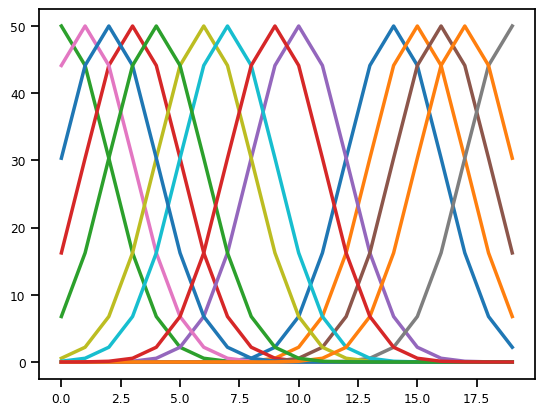

In [144]:
print(Xtrain_tensor.shape[0]*  Xtrain_tensor.shape[1])
print(Xtrain_tensor.shape[0], Xtrain_tensor.shape[1])
get_stimuli_input(Xtrain_tensor[0,:,:])
ok =  Xtrain_tensor.permute(2,1,0)
plt.plot(np.arange(0,20), ok[:,200,:])

In [145]:
for batch in range(0, Xtrain_tensor.shape[0]):
    print(get_stimuli_input(Xtrain_tensor[batch,:,:]))

tensor(14)
tensor(15)
tensor(0)
tensor(3)
tensor(10)
tensor(16)
tensor(1)
tensor(19)
tensor(6)
tensor(7)
tensor(2)
tensor(17)
tensor(4)
tensor(9)


In [156]:
print(Xtrain_tensor.shape[1])

499


In [160]:
Batch_Time_Dim = Xtrain_tensor.shape[0]*  Xtrain_tensor.shape[1]
Ytarget_index = torch.zeros((Batch_Time_Dim))
Ytime = 0
for batch in range(0, Xtrain_tensor.shape[0]):
    for time in range(0, Xtrain_tensor.shape[1]):
        Ytarget_index[time + Ytime] = get_stimuli_input(Xtrain_tensor[batch,:,:]).item()
    Ytime += Xtrain_tensor.shape[1]
        #Ytarget_index[time] = rand_indices[:val_split_index][batch]
    print(Ytarget_index)


tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  0.,  0.,  0.])
tensor([14., 14., 14.,  ...,  9.,  9.,  9.])


6986
14.0
torch.Size([6986])


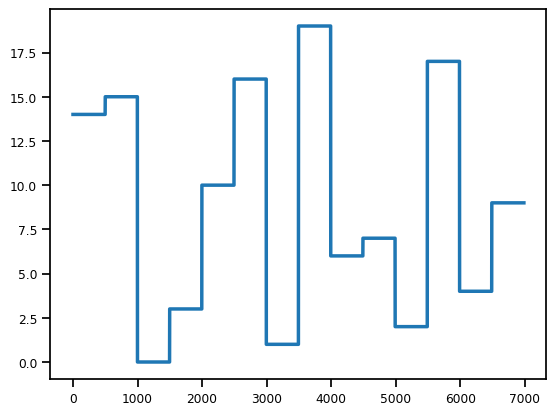

In [161]:

print(len(Ytarget_index))
print(Ytarget_index.numpy()[0])
print(Ytarget_index.shape)

plt.plot(np.arange(0,Ytarget_index.shape[0]),Ytarget_index)

In [184]:
log_probs = torch.randn(100, 10)  # Example log probabilities
target = torch.randint(0, 10, (100,))  # Example target with class indices

print(log_probs[0])
print(target)
# Apply log_softmax
log_probs_2 = F.log_softmax(log_probs, dim=1)

# Compute NLLLoss
criterion = nn.NLLLoss()
loss = criterion(log_probs, target)

tensor([ 0.5282, -0.9861, -2.0584,  0.2970, -0.1157,  0.0732,  1.4095,  1.0389,
         0.6563, -1.1029])
torch.Size([100])


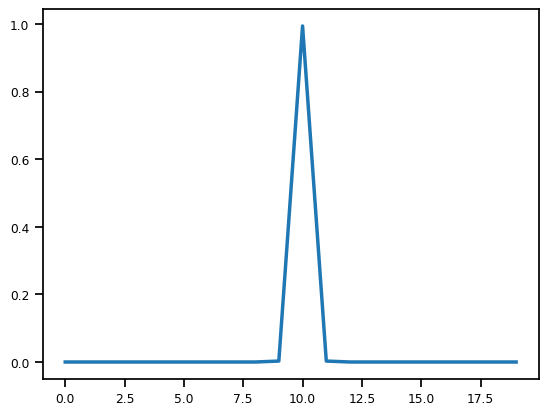

In [189]:
Xtrain_forloss = Xtrain_tensor.reshape(14 * 499, 20)

logsoft = nn.LogSoftmax(dim=1)
#log_probs_2 = F.log_softmax(Xtrain_forloss, dim=1)
#log_probs_2 = logsoft(Xtrain_forloss)
log_probs_2 = F.softmax(Xtrain_forloss, dim=1)

criterion(log_probs_2, Ytarget_index.long())
#Xtrain_forloss.shape
plt.plot(np.arange(20),log_probs_2[2000,:])

In [ ]:
def custom_loss_(re, Target, derivativeE, derivativeI):
  ic(torch.max(re))
  #1/ Proba term
  
  #logsoft = nn.LogSoftmax(dim=1)
  #pred = logsoft(re.t())  #   F.softmax(re.t(), dim=-1)#pred = F.softmax(re, dim=-1) #pred = make_it_proba(re)
  #target = Target[1,:].long()  
  #proba = make_it_proba(re) #F.softmax(re.t(), dim=1)

  lossfunc = torch.nn.NLLLoss()
  #loss_proba_term = lossfunc(pred, target)
  loss_proba_term = F.nll_loss(proba.t(), target) #F.nll_loss(F.softmax(re.t(), dim=1), target)
  
  
  #2/ derivative good 
  stimu_pop_ind= replace_argmax(Target) #stimu_pop= torch.argmax(Target).item()
  loss_derivative_term = - F.softplus(derivativeE[:,stimu_pop_ind] ).mean() + F.softplus(derivativeE[:, :stimu_pop_ind]).mean() + F.softplus(derivativeE[:, (stimu_pop_ind+1):]).mean()

  #sum instead of mean over time step
  #loss_derivative_term = - F.softplus(derivativeE[:,stimu_pop_ind] ).sum() + F.softplus(derivativeE[:, :stimu_pop_ind]).sum() + F.softplus(derivativeE[:, (stimu_pop_ind+1):]).sum()

  #3/ L2 regu term
  """l2_reg_coef=0.0001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum(param**2)
  
  #L2_term = l2_reg * l2_reg_coef
  """
  #4/ High value of re term
  # I have to change that !! firing rate still decreased after loss
  """
    high_activity_penalty_coef=0.01

  if torch.max(re[:,stimu_pop]) > 50: #60
     high_activity_penalty = torch.sum(torch.sum(re[:, stimu_pop]**2)) #torch.clamp(r_e[:, 7], max=10.0
  else:
     high_activity_penalty = 0
  
  #activity_regularization = high_activity_penalty * high_activity_penalty_coef
    """
  loss_derivative_term_tot =  0.001* loss_derivative_term
  Cost = loss_derivative_term_tot+ loss_proba_term# + activity_regularization + L2_term 
  ic(loss_derivative_term_tot, loss_proba_term)
  return Cost


### Optimization for batch

In [ ]:
def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    #print(Y_pred_prob.max())
    return torch.mean((Y_pred_prob - target)**2)

In [ ]:
Ytrain_tensor.shape

torch.Size([14, 499, 20])

In [214]:
def optimizerloop_BIG(model, train_dataloader, loss_f, Opt_name,learningRate, num_epoch):
  losses = torch.zeros(num_epoch) # used to plot the loss at the end
  model.train()
  for epoch in range(num_epoch):
    
    if Opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(),
                      lr=learningRate, weight_decay = 0.001)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    elif Opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(),
                      lr=learningRate)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
        
    # Clear the gradients
    optimizer.zero_grad()
    Y_prediction = torch.zeros(Ytrain_tensor.shape)# torch.nan

    for j,(x_train,y_train) in enumerate(train_dataloader):

      #model = MyModel_time()
      # Calculate output
      Y_prediction[j,:,:], I, dredt, dridt = model(x_train[0])
      #ic(Y_prediction.grad)
    # Calculate loss
      
    if loss_f == "easyLoss": #should NOT work
      Y_prediction_prob = make_it_proba(Y_prediction)
      loss = easyLoss(Y_prediction_prob, y_train[0])
    
    elif loss_f == "custom_loss_":
      #loss = custom_loss_(Y_prediction, y_train[0], dredt, dridt)
      Y_forloss = Y_prediction.reshape(14 * 499, 20)
      log_probs_2 = F.softmax(Y_forloss, dim=1)
      loss = criterion(log_probs_2, Ytarget_index.long())
      #ic(loss.grad)
    #accuracy
    #predicted = model(torch.tensor(x_train[0],dtype=torch.float32))
    acc = 0#(Y_prediction_prob.detach().round() == y_train[0]).float().mean() #.reshape(-1)

    #backprop
    loss.backward()
    optimizer.step()
  
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
    print("total_loss.grad: ",loss.grad_fn, "x_train.grad", x_train[0].grad_fn,"y_train.grad", y_train[0].grad_fn)
    for par in mymodel.parameters():
      print(par.grad)
    

  return list(model.parameters()), losses, acc,optimizer

### Inputs and Labels

In [208]:
# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = sti
#Y_prediction_prob =
Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input

#print(custom_loss_(r_e, Y_target, dredt, dridt))

In [ ]:
"""loss_derivative = - F.softplus(dredt[:,8] ).mean() + F.softplus(dredt[:, :8]).mean() + F.softplus(dredt[:, (8+1):]).mean()

plt.plot(np.arange(0, 499), F.softplus(dredt[:,8] ).detach().numpy())

print(F.softplus(dredt[:,8] ).mean())
"""

'loss_derivative = - F.softplus(dredt[:,8] ).mean() + F.softplus(dredt[:, :8]).mean() + F.softplus(dredt[:, (8+1):]).mean()\n\nplt.plot(np.arange(0, 499), F.softplus(dredt[:,8] ).detach().numpy())\n\nprint(F.softplus(dredt[:,8] ).mean())\n'

In [ ]:
#replace x input by max value of re just for investigation
#X_input.where(X_input ==1, torch.max(r_e, 1))

### Run 

In [218]:
#SGD + Mean Loss
num_epochs = 30
#lr = .0000001
lr = .000001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_

#param_new, losses_list, accuracy,optimizer_trained = optimizerloop_BIG(mymodel, train_dataloader, "easyLoss", "Adam",lr, num_epochs) # easyLoss
param_new, losses_list, accuracy,optimizer_trained = optimizerloop_BIG(mymodel, train_dataloader, "custom_loss_", "Adam",lr, num_epochs) # easyLoss


C:\Users\knzga\AppData\Local\Temp\ipykernel_2152\2085706392.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  ic(loss.grad)
ic| loss.grad: None


Epoch [1/30], Loss: -0.13852857053279877
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B55000> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(1.5580, dtype=torch.float64)
tensor(0.0725, dtype=torch.float64)
tensor(-0.0029, dtype=torch.float64)
tensor(0.7590, dtype=torch.float64)


ic| loss.grad: None


Epoch [2/30], Loss: -0.06810665130615234
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA21FDF90> x_train.grad None y_train.grad None
tensor(0.0005, dtype=torch.float64)
tensor(1.7405, dtype=torch.float64)
tensor(0.0798, dtype=torch.float64)
tensor(-0.0031, dtype=torch.float64)
tensor(0.9548, dtype=torch.float64)


ic| loss.grad: None


Epoch [3/30], Loss: -0.06525792926549911
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA21FDF90> x_train.grad None y_train.grad None
tensor(0.0005, dtype=torch.float64)
tensor(2.3273, dtype=torch.float64)
tensor(0.0998, dtype=torch.float64)
tensor(-0.0036, dtype=torch.float64)
tensor(2.6804, dtype=torch.float64)


ic| loss.grad: None


Epoch [4/30], Loss: -0.006449084263294935
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F975E40> x_train.grad None y_train.grad None
tensor(-0.0007, dtype=torch.float64)
tensor(-2.9047, dtype=torch.float64)
tensor(-0.1298, dtype=torch.float64)
tensor(0.0048, dtype=torch.float64)
tensor(-2.2734, dtype=torch.float64)


ic| loss.grad: None


Epoch [5/30], Loss: -0.08044073730707169
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9363BF10> x_train.grad None y_train.grad None
tensor(-0.0007, dtype=torch.float64)
tensor(-3.4404, dtype=torch.float64)
tensor(-0.1495, dtype=torch.float64)
tensor(0.0054, dtype=torch.float64)
tensor(-3.9174, dtype=torch.float64)


ic| loss.grad: None


Epoch [6/30], Loss: -0.15119588375091553
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9762C0> x_train.grad None y_train.grad None
tensor(-0.0007, dtype=torch.float64)
tensor(-3.4589, dtype=torch.float64)
tensor(-0.1504, dtype=torch.float64)
tensor(0.0054, dtype=torch.float64)
tensor(-3.9622, dtype=torch.float64)


ic| loss.grad: None


Epoch [7/30], Loss: -0.06647809594869614
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AE800> x_train.grad None y_train.grad None
tensor(0.0003, dtype=torch.float64)
tensor(1.7781, dtype=torch.float64)
tensor(0.0817, dtype=torch.float64)
tensor(-0.0030, dtype=torch.float64)
tensor(1.4319, dtype=torch.float64)


ic| loss.grad: None


Epoch [8/30], Loss: -0.18626582622528076
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9762C0> x_train.grad None y_train.grad None
tensor(0.0025, dtype=torch.float64)
tensor(11.5129, dtype=torch.float64)
tensor(0.5185, dtype=torch.float64)
tensor(-0.0193, dtype=torch.float64)
tensor(9.4710, dtype=torch.float64)


ic| loss.grad: None


Epoch [9/30], Loss: -0.0753059983253479
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9E08CE80> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.5991, dtype=torch.float64)
tensor(-0.1174, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.3818, dtype=torch.float64)


ic| loss.grad: None


Epoch [10/30], Loss: -0.06507490575313568
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9766B0> x_train.grad None y_train.grad None
tensor(0.0005, dtype=torch.float64)
tensor(2.3118, dtype=torch.float64)
tensor(0.1011, dtype=torch.float64)
tensor(-0.0035, dtype=torch.float64)
tensor(2.7595, dtype=torch.float64)


ic| loss.grad: None


Epoch [11/30], Loss: -0.12539519369602203
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F976CE0> x_train.grad None y_train.grad None
tensor(0.0017, dtype=torch.float64)
tensor(7.1694, dtype=torch.float64)
tensor(0.3182, dtype=torch.float64)
tensor(-0.0116, dtype=torch.float64)
tensor(6.6742, dtype=torch.float64)


ic| loss.grad: None


Epoch [12/30], Loss: -0.0681689977645874
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F976CE0> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(1.6633, dtype=torch.float64)
tensor(0.0781, dtype=torch.float64)
tensor(-0.0030, dtype=torch.float64)
tensor(0.8457, dtype=torch.float64)


ic| loss.grad: None


Epoch [13/30], Loss: -0.13102275133132935
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AC910> x_train.grad None y_train.grad None
tensor(0.0024, dtype=torch.float64)
tensor(7.1642, dtype=torch.float64)
tensor(0.3098, dtype=torch.float64)
tensor(-0.0111, dtype=torch.float64)
tensor(5.8789, dtype=torch.float64)


ic| loss.grad: None


Epoch [14/30], Loss: -0.0650118961930275
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AE200> x_train.grad None y_train.grad None
tensor(0.0005, dtype=torch.float64)
tensor(2.4425, dtype=torch.float64)
tensor(0.1048, dtype=torch.float64)
tensor(-0.0037, dtype=torch.float64)
tensor(2.8388, dtype=torch.float64)


ic| loss.grad: None


Epoch [15/30], Loss: -0.06479039788246155
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9363BF10> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(2.2459, dtype=torch.float64)
tensor(0.0994, dtype=torch.float64)
tensor(-0.0036, dtype=torch.float64)
tensor(2.5287, dtype=torch.float64)


ic| loss.grad: None


Epoch [16/30], Loss: -0.18833443522453308
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9766B0> x_train.grad None y_train.grad None
tensor(0.0027, dtype=torch.float64)
tensor(11.4217, dtype=torch.float64)
tensor(0.5143, dtype=torch.float64)
tensor(-0.0192, dtype=torch.float64)
tensor(8.7481, dtype=torch.float64)


ic| loss.grad: None


Epoch [17/30], Loss: -0.37910735607147217
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9766B0> x_train.grad None y_train.grad None
tensor(0.0058, dtype=torch.float64)
tensor(22.4597, dtype=torch.float64)
tensor(0.9887, dtype=torch.float64)
tensor(-0.0359, dtype=torch.float64)
tensor(19.5758, dtype=torch.float64)


ic| loss.grad: None


Epoch [18/30], Loss: -0.004525265656411648
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AF220> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.5928, dtype=torch.float64)
tensor(-0.1168, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.3577, dtype=torch.float64)


ic| loss.grad: None


Epoch [19/30], Loss: -0.011125420220196247
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F976A10> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-3.9943, dtype=torch.float64)
tensor(-0.1706, dtype=torch.float64)
tensor(0.0059, dtype=torch.float64)
tensor(-4.9031, dtype=torch.float64)


ic| loss.grad: None


Epoch [20/30], Loss: -0.13975971937179565
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B08DF0> x_train.grad None y_train.grad None
tensor(0.0012, dtype=torch.float64)
tensor(2.6727, dtype=torch.float64)
tensor(0.1058, dtype=torch.float64)
tensor(-0.0034, dtype=torch.float64)
tensor(2.8573, dtype=torch.float64)


ic| loss.grad: None


Epoch [21/30], Loss: -0.06463075429201126
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B08DF0> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(2.3556, dtype=torch.float64)
tensor(0.1028, dtype=torch.float64)
tensor(-0.0037, dtype=torch.float64)
tensor(2.5779, dtype=torch.float64)


ic| loss.grad: None


Epoch [22/30], Loss: -0.06644776463508606
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B08DF0> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(2.0284, dtype=torch.float64)
tensor(0.0908, dtype=torch.float64)
tensor(-0.0033, dtype=torch.float64)
tensor(1.8003, dtype=torch.float64)


ic| loss.grad: None


Epoch [23/30], Loss: -0.06808313727378845
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9766B0> x_train.grad None y_train.grad None
tensor(0.0004, dtype=torch.float64)
tensor(1.6674, dtype=torch.float64)
tensor(0.0778, dtype=torch.float64)
tensor(-0.0030, dtype=torch.float64)
tensor(0.8790, dtype=torch.float64)


ic| loss.grad: None


Epoch [24/30], Loss: -0.2572593688964844
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B551E0> x_train.grad None y_train.grad None
tensor(0.0025, dtype=torch.float64)
tensor(11.5152, dtype=torch.float64)
tensor(0.5176, dtype=torch.float64)
tensor(-0.0192, dtype=torch.float64)
tensor(9.4118, dtype=torch.float64)


ic| loss.grad: None


Epoch [25/30], Loss: -0.007453481201082468
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AF610> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-3.3171, dtype=torch.float64)
tensor(-0.1450, dtype=torch.float64)
tensor(0.0052, dtype=torch.float64)
tensor(-3.1205, dtype=torch.float64)


ic| loss.grad: None


Epoch [26/30], Loss: -0.12497393786907196
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA1B551E0> x_train.grad None y_train.grad None
tensor(0.0015, dtype=torch.float64)
tensor(7.1444, dtype=torch.float64)
tensor(0.3181, dtype=torch.float64)
tensor(-0.0117, dtype=torch.float64)
tensor(6.4588, dtype=torch.float64)


ic| loss.grad: None


Epoch [27/30], Loss: -0.1973392814397812
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AD360> x_train.grad None y_train.grad None
tensor(0.0015, dtype=torch.float64)
tensor(6.8540, dtype=torch.float64)
tensor(0.3076, dtype=torch.float64)
tensor(-0.0113, dtype=torch.float64)
tensor(5.6249, dtype=torch.float64)


ic| loss.grad: None


Epoch [28/30], Loss: -0.0078583350405097
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AD360> x_train.grad None y_train.grad None
tensor(-0.0007, dtype=torch.float64)
tensor(-3.2163, dtype=torch.float64)
tensor(-0.1405, dtype=torch.float64)
tensor(0.0051, dtype=torch.float64)
tensor(-3.0767, dtype=torch.float64)


ic| loss.grad: None


Epoch [29/30], Loss: -0.07088927924633026
total_loss.grad:  <NllLossBackward0 object at 0x000001AD9F9768C0> x_train.grad None y_train.grad None
tensor(0.0013, dtype=torch.float64)
tensor(2.3653, dtype=torch.float64)
tensor(0.0932, dtype=torch.float64)
tensor(-0.0030, dtype=torch.float64)
tensor(1.9880, dtype=torch.float64)


ic| loss.grad: None


Epoch [30/30], Loss: -0.004723860416561365
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA24AE230> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


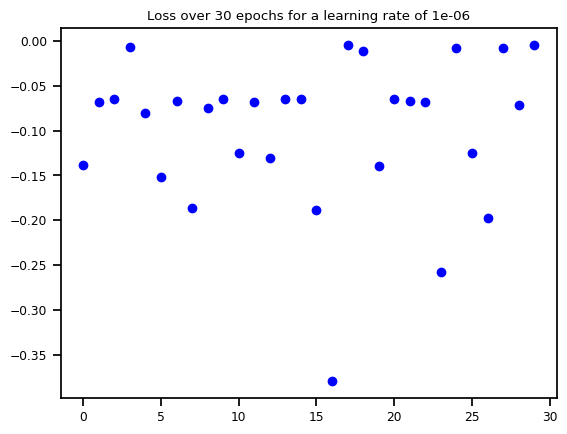

In [220]:
plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

# Save trained parameters and use them in a new model

In [ ]:
print(batch_training_size)

In [ ]:

Xtrain_tensor.shape

old model Parameter containing:
tensor(0.0720, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0720, dtype=torch.float64, requires_grad=True)


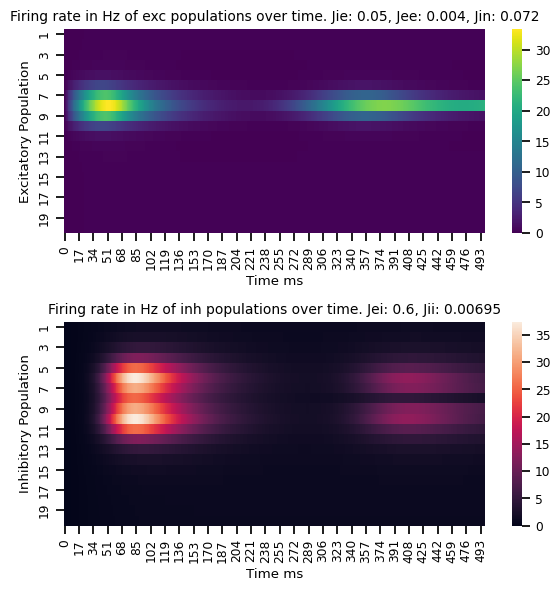

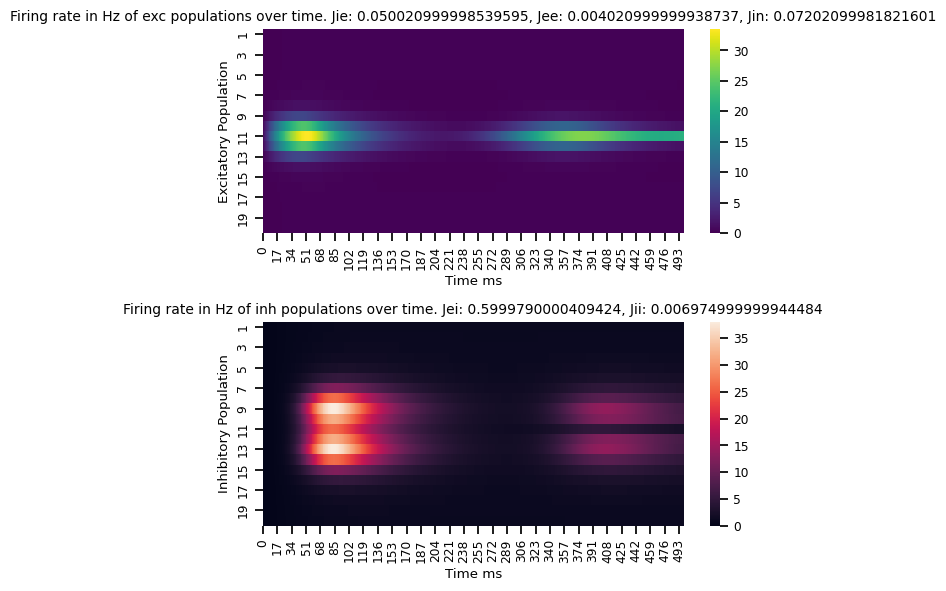

In [221]:
#Use a function which save parameters of trained model and upload the new model with the updated parameters


trained_model, optimizer_trained = model_with_saved_trained_param(mymodel, optimizer_trained, MyModel_time) #optimizer_trained

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RE_trained = torch.zeros(Xtrain_tensor.shape)
RI_trained = torch.zeros(Xtrain_tensor.shape)
dREdt_trained = torch.zeros(Xtrain_tensor.shape)
dRIdt_trained = torch.zeros(Xtrain_tensor.shape)

for batch in range(batch_training_size):
    RE_trained[batch,:,:], RI_trained[batch,:,:], dREdt_trained[batch,:,:], dRIdt_trained[batch,:,:] = trained_model.forward(Xtrain_tensor[batch,:,:]) #Xtrain_tensor[2,:,:]

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)

J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(RE_trained[4,:,:].detach().numpy(), RI_trained[4,:,:].detach().numpy(), J2)


[ 0.11990055  0.12680608  0.15591323  0.2769505   0.8979482   4.589577
 14.432903   18.88926    14.432893    4.589564    0.8979427   0.27694768
  0.1559109   0.12680346  0.11989733  0.11852619  0.1183176   0.11829667
  0.11829732  0.11829899]


ic| r_e_trained[i,:].shape: torch.Size([20])


[0.00416727 0.0044013  0.00539895 0.00955482 0.03083932 0.15787864
 0.50397086 0.6632328  0.5039685  0.15787515 0.03083798 0.00955422
 0.0053985  0.00440084 0.00416674 0.00412209 0.00411638 0.00411642
 0.00411683 0.00411712]


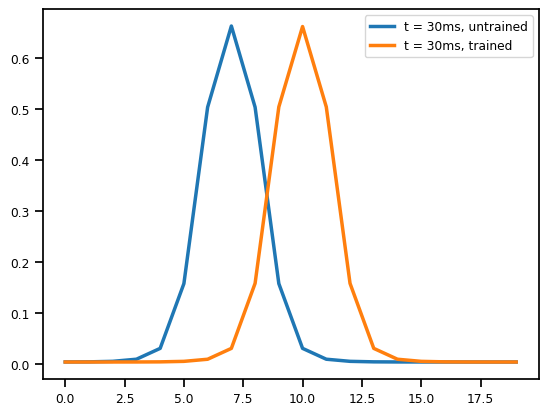

In [226]:
t = 40
t2 = 30
t3 = 10
r_e_trained = RE_trained[4,:,:]

from sklearn import preprocessing
re_numpy = np.array(r_e.detach().numpy())
re_numpy_train = np.array(r_e_trained.detach().numpy())
print(np.array(re_numpy[20,:]))


re_tr_norm = preprocessing.normalize(re_numpy_train, axis= 1) #torch.zeros(r_e_trained.shape)
re_norm = preprocessing.normalize(re_numpy, axis= 1) #torch.zeros(r_e_trained.shape)
ic(r_e_trained[i,:].shape)

"""for i in range(r_e_trained.shape[0]):
    re_tr_norm[i,:] = preprocessing.normalize(r_e_trained[i,:].detach().numpy())# / retrained_t2[i,:].sum()
    re_norm[i,:] = preprocessing.normalize(r_e[i,:])# / r_e[i,:].sum()
"""
print(re_norm[30,:])

#plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t,:], label = f"{t} trained")
#plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t,:], label = f"{t} untrained")

plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t2,:], label = f"t = {t2}ms, untrained")
plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t2,:], label = f"t = {t2}ms, trained")

#plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t3,:], label = f"{t3} trained")
#plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t3,:], label = f"{t3} untrained")

#plt.plot(np.arange((r_e_bad[t,:].detach().numpy()).shape[0]), r_e_bad[t,:].detach().numpy(), label = f"bad {t}")
#plt.plot(np.arange((r_e_bad[t2,:].detach().numpy()).shape[0]), r_e_bad[t2,:].detach().numpy(), label = f"bad {t2}")

plt.legend()

# Do the test with new parameters

In [223]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class BadParamModel(nn.Module):
    def __init__(self):
        super(BadParamModel, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.04, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.001, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.01, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00595, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulan =torch.mul(a, I_tot)

        multi= mulan + b

        expo = torch.exp(- (multi))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




tensor(10.4172, grad_fn=<MaxBackward1>)


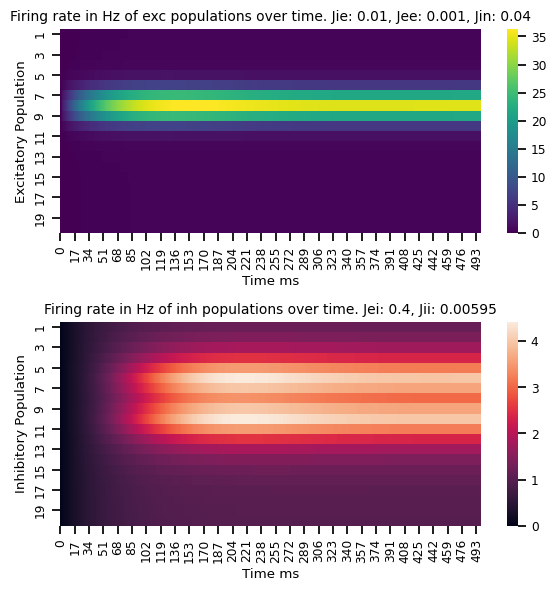

In [224]:
"""*
*  Forward pass for bad parameter
*
*
"""

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mybadmodel = BadParamModel()
J_bad = {'Jee': mybadmodel.Jee.detach().numpy(), 'Jei': mybadmodel.Jei.detach().numpy(), 'Jie': mybadmodel.Jie.detach().numpy(), 'Jii': mybadmodel.Jii.detach().numpy()
      , 'Jin': mybadmodel.Jin.detach().numpy()}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_bad, r_i_bad, dredt_bad, dridt_bad = mybadmodel.forward(sti)
print(torch.max(r_e[10,:]))
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)

In [225]:
#SGD + Mean Loss
num_epochs = 10
lr = .001

param_new, losses_list_bad, accuracy_bad, optimizer_trained_bad = optimizerloop_BIG(mybadmodel,train_dataloader , "custom_loss_", "Adam",lr, num_epochs) # easyLoss #custom_loss_


param_new, losses_list, accuracy,optimizer_trained = optimizerloop_BIG(mymodel, train_dataloader, "easyLoss", "Adam",lr, num_epochs) # easyLoss



C:\Users\knzga\AppData\Local\Temp\ipykernel_2152\2085706392.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  ic(loss.grad)
ic| loss.grad: None


Epoch [1/10], Loss: -0.14210085570812225
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF289CBB0> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [2/10], Loss: -0.14162683486938477
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA19B4820> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [3/10], Loss: -0.0004120790690649301
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA19B4820> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [4/10], Loss: -0.07109136879444122
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF289D780> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [5/10], Loss: -0.14120478928089142
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF2A3C670> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [6/10], Loss: -0.0005135256797075272
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF2A3C2E0> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [7/10], Loss: -0.14159071445465088
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF289C8B0> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [8/10], Loss: -0.0009855631506070495
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF289C8B0> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [9/10], Loss: -0.07132422924041748
total_loss.grad:  <NllLossBackward0 object at 0x000001ADF289C8B0> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


ic| loss.grad: None


Epoch [10/10], Loss: -0.0020646126940846443
total_loss.grad:  <NllLossBackward0 object at 0x000001ADA22C0A30> x_train.grad None y_train.grad None
tensor(-0.0008, dtype=torch.float64)
tensor(-2.6629, dtype=torch.float64)
tensor(-0.1200, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64)
tensor(-1.4751, dtype=torch.float64)


RuntimeError: shape '[14, 1]' is invalid for input of size 280

In [ ]:
plt.plot(np.arange(losses_list_bad.shape[0]), losses_list_bad.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

In [ ]:
trained_bad_model, optimizer_bad_trained = model_with_saved_trained_param(mybadmodel, optimizer_trained_bad, BadParamModel)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

r_e_bad_trained, r_i_bad_trained, dredt_bad_trained, dridt_bad_trained = trained_bad_model.forward(sti) #Xtrain_tensor[2,:,:]
ic(torch.max(r_e_bad))
ic(torch.max(r_e_bad_trained))

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)
J2= {'Jee': trained_bad_model.Jee.detach().numpy(), 'Jei': trained_bad_model.Jei.detach().numpy(), 'Jie': trained_bad_model.Jie.detach().numpy(), 'Jii': trained_bad_model.Jii.detach().numpy(), 'Jin': trained_bad_model.Jin.detach().numpy()}
HeatMap(r_e_bad_trained.detach().numpy(), r_i_bad_trained.detach().numpy(), J2)

In [ ]:
t = 10
t2= 4
#plt.plot(np.arange((r_e[t,:].detach().numpy()).shape[0]), r_e[t,:].detach().numpy(), label = f"time {t} ms")
#plt.plot(np.arange((r_e[t2,:].detach().numpy()).shape[0]), r_e[t2,:].detach().numpy(), label = f"time {t2} ms")
plt.plot(np.arange((r_e_bad[t,:].detach().numpy()).shape[0]), r_e_bad[t,:].detach().numpy(), label = f"bad param {t} ms")
plt.plot(np.arange((r_e_bad[t2,:].detach().numpy()).shape[0]), r_e_bad[t2,:].detach().numpy(), label = f"bad param {t2} ms")
plt.plot(np.arange((r_e_bad_trained[t,:].detach().numpy()).shape[0]), r_e_bad_trained[t,:].detach().numpy(), label = f"bad param trained {t} ms")
plt.plot(np.arange((r_e_bad_trained[t2,:].detach().numpy()).shape[0]), r_e_bad_trained[t2,:].detach().numpy(), label = f"bad param trained {t2} ms")
plt.legend()

